# **Building Music Recommendation System using Spotify Dataset**

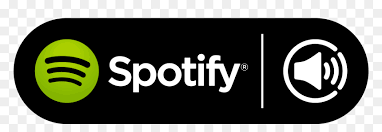

Hello and welcome to my kernel. In this kernel, I have created Music Recommendation System using Spotify Dataset. To do this, I presented some of the visualization processes to understand data and done some EDA(Exploratory Data Analysis) so we can select features that are relevant to create a Recommendation System.

# **Import Libraries**

In [13]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

# **Read Data**

In [14]:
# Load dataset
data = pd.read_csv("../input/spotify-dataset/data/data.csv")

# Simulate 'repeated_play' column with random integer values (e.g., 0 to 10 replays per month)
np.random.seed(42)  # For reproducibility
data['repeated_play'] = np.random.randint(0, 11, size=len(data))

# Verify the new column
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,repeated_play
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,6
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,3
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,10
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,7
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,4


In [15]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

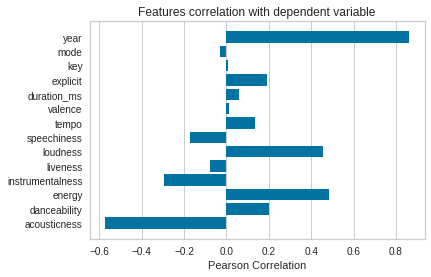

In [16]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

# **Clustering with K-Means**

In [17]:
from sklearn.cluster import KMeans

# Features and target variable
features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 
            'duration_ms', 'explicit', 'key', 'mode', 'year']

X = data[features]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters (optional step, e.g., using the Elbow Method)
# For simplicity, we'll use a fixed number of clusters
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Verify clusters
print(data[['id', 'cluster']].head())


                       id  cluster
0  4BJqT0PrAfrxzMOxytFOIz        9
1  7xPhfUan2yNtyFG0cUWkt8        2
2  1o6I8BglA6ylDMrIELygv1        8
3  3ftBPsC5vPBKxYSee08FDH        1
4  4d6HGyGT8e121BsdKmw9v6        1


# **Recommendations**

In [23]:
# Function to recommend songs from the same cluster
def recommend_songs(song_id, data, n_recommendations=5):
    cluster = data.loc[data['id'] == song_id, 'cluster'].values[0]
    similar_songs = data[data['cluster'] == cluster]
    
    # Exclude the input song from the recommendations
    recommendations = similar_songs[similar_songs['id'] != song_id]
    
    # Sort recommendations by the number of replays (descending order)
    recommendations = recommendations.sort_values(by='repeated_play', ascending=False)
    
    # If the number of recommendations is less than requested, return all available
    return recommendations.head(n_recommendations)

# Example: Recommend songs for a given song_id
song_id = data.sample(n=1, random_state=42).iloc[0]['id']
recommendations = recommend_songs(song_id, data)
print(recommendations[['name', 'artists']])

                               name                      artists
85854                     Wa-Do-Dem              ['Eek-A-Mouse']
111882                        Poker         ['Charles Aznavour']
111828                   Whop, Whop     ['Sugar Chile Robinson']
147819                     Helpless  ['The Cleaners From Venus']
8802    Just Like Tom Thumb's Blues                ['Bob Dylan']
